In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from itertools import product

## 1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [2]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

def normal_equation(X, y):
    return np.linalg.inv(np.dot(X.T, X)) @ X.T @ y

In [3]:
def GD(X, y, lr=1e-2, accuracy=1e-6):
    n, n_features = X.shape
    W = np.random.rand(n_features)
    i, err = 0, float('inf')
    err_history = []
    while err > accuracy:
        y_pred = np.dot(X, W)
        new_err = calc_mse(y, y_pred)
        if new_err > err:
            return ('divergence',)
        err = new_err
        err_history.append(err)
        grad = X.T.dot(y_pred - y)
        W -= 2/n * lr * grad
        i += 1
    return i, W, err_history

In [4]:
def SGD(X, y, batch_size=1, lr=1e-4, accuracy=1e-6):
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    n_batch = n // batch_size
    if n % batch_size != 0:
        n_batch += 1
    i, batch, err = 0, 0, float('inf')
    err_history = []
    while err > accuracy:
        if batch == n_batch:
            batch = 0
            i += 1
            err_history.append(err)
            if i >= 100:
                return ('divergence',)  # принимаем что алгоритм расходится, если после 100 итераций точность не достигнута
        start_ = batch_size*batch
        end_ = batch_size*(batch+1)

        X_tmp = X[start_ : end_, :]
        y_tmp = y[start_ : end_]
        y_pred_tmp = np.dot(W, X_tmp.T)
        err = calc_mse(y_tmp, y_pred_tmp)
        W -= (lr * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp)))
        batch += 1
    return i, W, err_history

In [5]:
n_features = 5
X, y = make_regression(n_features=n_features)

##### Проверка работы алгоритмов

In [6]:
iterations_to_conv_GD, W, err_history_GD = GD(X, y, lr=0.5)
iterations_to_conv_GD, W, err_history_GD

(12,
 array([58.13842228, 82.58714343, 72.05902636, 16.71251516, 96.2626423 ]),
 [24491.93258614471,
  917.6449238217009,
  72.35591799894156,
  8.12314890424863,
  1.0296480632311387,
  0.1354055845535034,
  0.018001453585555608,
  0.0024010250301698638,
  0.00032057143845900084,
  4.2814764055628154e-05,
  5.718850643520017e-06,
  7.639056736184319e-07])

In [7]:
iterations_to_conv_SGD, W, err_history_SGD  = SGD(X,y, batch_size=20 ,lr=0.5)
iterations_to_conv_SGD, W, err_history_SGD

(12,
 array([58.13806422, 82.58737992, 72.05852001, 16.71227915, 96.26235584]),
 [6771.982083966356,
  804.0119651306453,
  107.13437408682164,
  15.264908670994762,
  2.263135688864761,
  0.34377778419677163,
  0.05302506434403622,
  0.008259654540648965,
  0.0012949722050887734,
  0.00020391625180139517,
  3.2205943982836425e-05,
  5.097009270914359e-06])

#### График изменения функции ошибок для различных значений размера батча
 Величины функции ошибок для стохастического градиентоного спуска вычисляется после каждого полного прохода по данным 

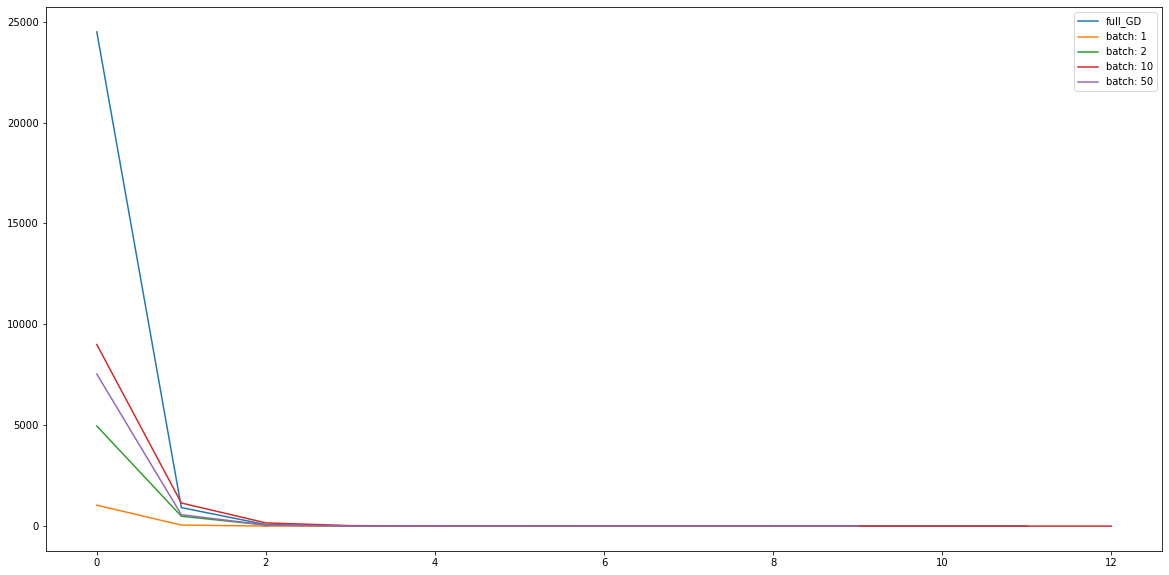

In [8]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(err_history_GD, label='full_GD')
for batch in [1, 2, 10, 50]:
    _, _, err_history_SGD  = SGD(X,y, batch_size=batch ,lr=0.5)
    plt.plot(err_history_SGD, label=f'batch: {batch}')
plt.legend()
plt.show()

По графику видно что стохастический градиентый спуск сходится быстрее

*Поиск оптимальных параметров скорости обучения и размера батча для полного и стохастического градиентного спуска

In [9]:
def grid_search(func, X, y, params):
    names, intervals = [], []
    convergence_rates = []
    for k, v in params.items():
        names.append(k)
        intervals.append(v)
    for i in product(*intervals):
        param = {k: v for k, v in zip(names, i)}
        convergence_rates.append((param, func(X, y, **param)[0]))
    convergence_rates = np.array([rate for rate in convergence_rates if rate[1] != 'divergence'])  # отбрасываем результаты при котором градиентый спуск не сходится
    return convergence_rates

In [10]:
convergence_rates_GD = grid_search(GD, X, y, {'lr': np.linspace(0.03, 1, 30)})
best_GD_params = min(convergence_rates_GD, key=lambda x: x[1])
best_GD_params

array([{'lr': 0.46482758620689657}, 10], dtype=object)

In [11]:
GD(X, y, **best_GD_params[0])

(10,
 array([58.1382813 , 82.58726512, 72.05900646, 16.71248332, 96.26265419]),
 [24540.172654478476,
  821.9037792810105,
  49.196288660156135,
  3.0535499376951662,
  0.19323996803595925,
  0.0124154720789402,
  0.0008088202643469555,
  5.3394499469844306e-05,
  3.569581566018312e-06,
  2.414642250268217e-07])

In [12]:
convergence_rates_SGD = grid_search(SGD, X, y, {'lr': np.linspace(0.03, 1, 30), 'batch_size': np.array([1, 2, 10, 50, 100])})
best_SGD_params = min(convergence_rates_SGD, key=lambda x: x[1])
best_SGD_params

array([{'lr': 0.8662068965517241, 'batch_size': 1}, 2], dtype=object)

In [13]:
SGD(X, y, **best_SGD_params[0])

(4,
 array([58.09208616, 82.5891057 , 71.94539384, 16.67868782, 96.20084763]),
 [115.0833359558608,
  0.08912954414527449,
  0.029099253549900343,
  0.004290139989102636])

В лучшем случае полный градиентый спуск сходится за 14 итераций, в то время как стохастический за 4

## 2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [14]:
def GD_reg(X, y, lr=1e-2, accuracy=1e-6, lambda_=1e-8, reg_ord=2):
    n, n_features = X.shape
    W = np.random.rand(n_features)
    i, err = 0, float('inf')
    err_history = []
    while err > accuracy:
        y_pred = np.dot(X, W)
        new_err = calc_mse(y, y_pred)
        if new_err > err:
            return ('divergence',)
        err = new_err
        err_history.append(err)
        grad = X.T.dot(y_pred - y)
        W -= 2/n * lr * (grad + lambda_ * np.linalg.norm(W, ord=reg_ord))
        i += 1
    return i, W, err_history

def SGD_reg(X, y, batch_size=1, lr=1e-4, accuracy=1e-6, lambda_=1e-8, reg_ord=2):
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    n_batch = n // batch_size
    if n % batch_size != 0:
        n_batch += 1
    i, batch, err = 0, 0, float('inf')
    err_history = []
    while err > accuracy:
        if batch == n_batch:
            batch = 0
            i += 1
            err_history.append(err)
            if i >= 100:
                return ('divergence',)  # принимаем что алгоритм расходится, если после 100 итераций точность не достигнута
        start_ = batch_size*batch
        end_ = batch_size*(batch+1)

        X_tmp = X[start_ : end_, :]
        y_tmp = y[start_ : end_]
        y_pred_tmp = np.dot(W, X_tmp.T)
        err = calc_mse(y_tmp, y_pred_tmp)
        W -= (lr * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp) + + lambda_ * np.linalg.norm(W, ord=reg_ord)))
        batch += 1
    return i, W, err_history

L2 регуляризация

In [15]:
GD_reg(X, y, **best_GD_params[0], reg_ord=2)

(10,
 array([58.13828203, 82.58726442, 72.05900625, 16.71248341, 96.26265394]),
 [24624.266687011994,
  826.2115393732258,
  49.52317337479366,
  3.0779128281257844,
  0.1950411841287684,
  0.012548038923671165,
  0.0008185476043277894,
  5.4106663387218375e-05,
  3.621678576750263e-06,
  2.4527168990313576e-07])

In [16]:
SGD_reg(X, y, **best_SGD_params[0], reg_ord=2)

(4,
 array([58.09257337, 82.58870617, 71.94722393, 16.67904262, 96.20179877]),
 [122.19394480928214,
  0.12662360037383544,
  0.025548256481837398,
  0.004012809249806045])

L1 регуляризация

In [17]:
GD_reg(X, y, **best_GD_params[0], reg_ord=1)

(10,
 array([58.13828224, 82.58726423, 72.05900639, 16.71248348, 96.26265398]),
 [24426.33862268707,
  821.4696299486403,
  49.32793875209005,
  3.06895708113844,
  0.19463056132855733,
  0.012530908990444739,
  0.0008180149740395681,
  5.4108654482445965e-05,
  3.62421450025286e-06,
  2.455961727588448e-07])

In [18]:
SGD_reg(X, y, **best_SGD_params[0], reg_ord=1)

(4,
 array([58.09287843, 82.58849752, 71.94799074, 16.67886001, 96.2025809 ]),
 [118.74196964516261,
  0.11938553090633837,
  0.025304591832421265,
  0.003940417346385303])

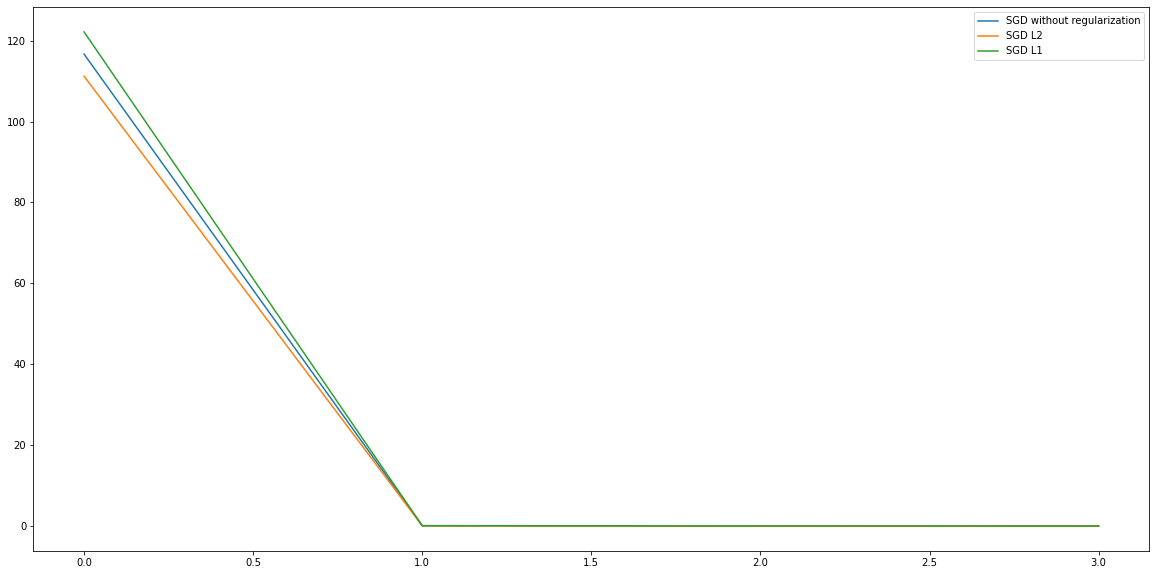

In [19]:
plt.rcParams["figure.figsize"] = (20, 10)
# plt.plot(GD(X, y, **best_GD_params[0])[2], label='GD without regularization')
# plt.plot(GD_reg(X, y, **best_GD_params[0], reg_ord=2)[2], label='GD L2')
# plt.plot(GD_reg(X, y, **best_GD_params[0], reg_ord=1)[2], label='GD L1')

plt.plot(SGD(X, y, **best_SGD_params[0])[2], label='SGD without regularization')
plt.plot(SGD_reg(X, y, **best_SGD_params[0], reg_ord=2)[2], label='SGD L2')
plt.plot(SGD_reg(X, y, **best_SGD_params[0], reg_ord=1)[2], label='SGD L1')
plt.legend()
plt.show()

На данных примерах регуляризация незначительно влияет на скорость сходимости градинтного спуска, иногда в лучшую, иногда в худшую сторону